- DADASAHEB SAWANT this side, 
- We are going to discuss about how to read spark query plan. This is very fundamental to spark
- It basically helps you HOW SPARK DOES THINGS INTERNALLY UNDER THE HOOD.?
- It is also very imp to do before doing any spark optimization.

# Imports & Configuration

- Importing the imp modules and spark API modules and creating the spark session and sparkcontext

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Reading File

- Reading two datasets 1. transactions.parquet and 2. customers.parquet for code snippets below


In [ ]:
transactions_file = "../data/data_skew/transactions.parquet"
df_transactions = spark.read.parquet(transactions_file)

In [ ]:
df_transactions.show(5, False)

In [ ]:
customers_file = "../data/data_skew/customers.parquet"
df_customers = spark.read.parquet(customers_file)

In [ ]:
df_customers.show(5, False)


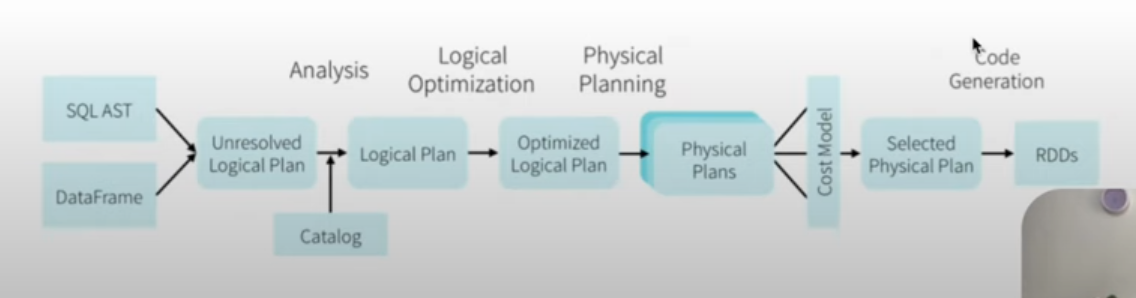
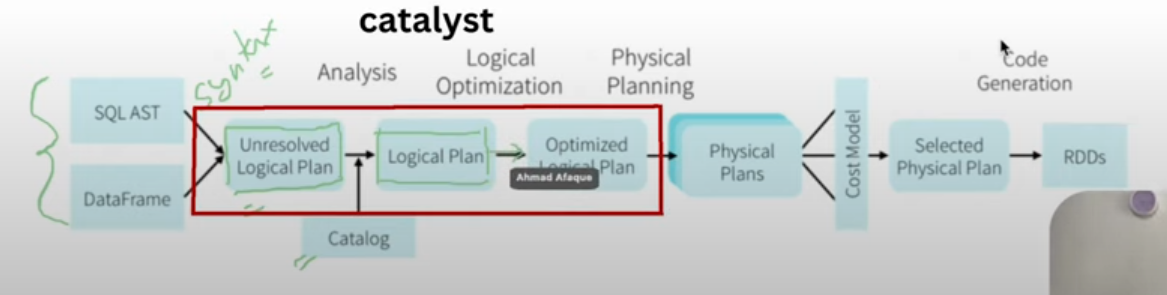

Some of the optimization done at catalyst optimizer those are:
- Fist it checks the syntax/grammer of the query/pyspark DF and created **Unresolved Logical Plan** **(Query --- syntax validation---> Unresolved Logical Plan)**
- Validates tables schema present in catalog. **(Unresolved Logical Pla --- catalog table validation --> Logical Plan)**
- filter pushdown. (if there is any filter middle or end of the code then it push to the start of code) **(Logical Plan ---optimization filter pushdown/ select --> Optimized Logical Plan)**
- pushdown projection (SELECT * FROM customers) spark checks what columns used and only those it select.
- And it creates **Optimized Logical Plan** and then converts into **Physical Plans**
- The physical plans are the one which actually runs on the cluster.
- This Physical Plans which goes to internal Cost Model and picks optimized one that executed on the cluster.



### 🎯 Example Query:

> SELECT name FROM customers WHERE age > 30;

### Or using DataFrame API:


>> df = spark.read.csv("customers.csv", header=True, inferSchema=True)

>> df.filter(df.age > 30).select("name")

### ⚙️ Spark Execution Components (Step-by-Step)

1. 🧱 SQL AST (Abstract Syntax Tree)

- In Apache Spark, the syntax of your query is primarily checked at the very first stage of the query execution pipeline — during the SQL AST (Abstract Syntax Tree) generation.

- Spark parses your SQL into a tree-like structure:

- Project(name)
 
 └── Filter(age > 30)
     
     └── Table(customers)

2. 📊 DataFrame API

- In Apache Spark, the syntax of your query is primarily checked at the very first stage of the query execution pipeline — during the SQL AST (Abstract Syntax Tree) generation or in DataFrame.


Code like:

>> df.filter(df.age > 30).select("name")

Builds a lazy logical plan, but doesn’t run yet.

3. ❓ Unresolved Logical Plan
Spark generates an initial plan:

Project(name)

 └── Filter(age > 30)
 
      └── UnresolvedRelation(employees)
      
4. 📚 Catalog (Validation)
Spark checks:

Is table present in catlog?

Do columns name, age exist?

5. ✅ Logical Plan (Resolved)
Now Spark knows data types, table location, etc.

Project(name: String)

 └── Filter(age > 30)
 
      └── Relation(employees.csv)
      
6. 🧠 Optimized Logical Plan
Spark applies optimization rules:

Project(name)

 └── Filter(age > 30)
 
      └── Relation(employees.csv)  (only loads name & age columns)

7. ⚡ Physical Plan (Multiple Candidates)
Spark generates multiple strategies to execute:

Full scan

Broadcast join

Sort merge join

8. 📈 Cost Model
Spark estimates cost:

Memory

I/O

CPU

Then picks the lowest-cost plan.

9. 🏁 Selected Physical Plan
Final plan Spark will run:

*(1) Project [name]
+- *(1) Filter (age > 30)
   +- FileScan csv [name, age]
Use:

df.filter(df.age > 30).select("name").explain()

10. 🔧 RDD Code Generation
Spark generates RDD code:

Read CSV rows

Filter age > 30

Return only name column

🔁 Full Flow Diagram:

SQL / DataFrame
   ↓
SQL AST / Unresolved Logical Plan
   ↓
Catalog Validation
   ↓
Logical Plan (resolved)
   ↓
Optimized Logical Plan
   ↓
Multiple Physical Plans
   ↓
Cost Model selects best one
   ↓
Selected Physical Plan
   ↓
RDD Code Generation & Execution

✅ TL;DR Summary Table

Component	Meaning
SQL AST	Syntax tree from your SQL query
DataFrame	Lazy execution plan built with transformations
Unresolved Logical Plan	Initial plan without column/table validation
Catalog	Spark’s metadata database (table and column info)
Logical Plan	Verified version of your plan
Optimized Logical Plan	Improved version using optimization rules
Physical Plan	Candidate execution strategies
Cost Model	Chooses best physical plan based on cost estimation
Selected Physical Plan	Final plan chosen for execution
RDD Code Generation	Converts plan to actual Spark RDD tasks that run on cluster



![Spark Execution](../data/spark-execution.png)

# Narrow Transformations

- We will see few narrow transformations to understand how the query plans created
- `filter` rows where `city='boston'`
- `add` a new column: adding `first_name` and `last_name`
- `alter` an exisitng column: adding 5 to `age` column
- `select` relevant columns

In [ ]:
df_narrow_transform = (
    df_customers
    .filter(F.col("city") == "boston")
    .withColumn("first_name", F.split("name", " ").getItem(0))
    .withColumn("last_name", F.split("name", " ").getItem(1))
    .withColumn("age", F.col("age") + F.lit(5))
    .select("cust_id", "first_name", "last_name", "age", "gender", "birthday")
)

df_narrow_transform.show(5, False)
df_narrow_transform.explain(True)

Output of above cell:

> df_narrow_transform.show(5, False)
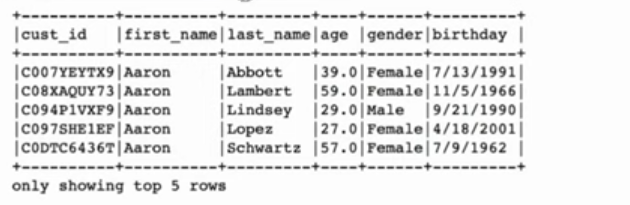

> df_narrow_transform.explain(True)
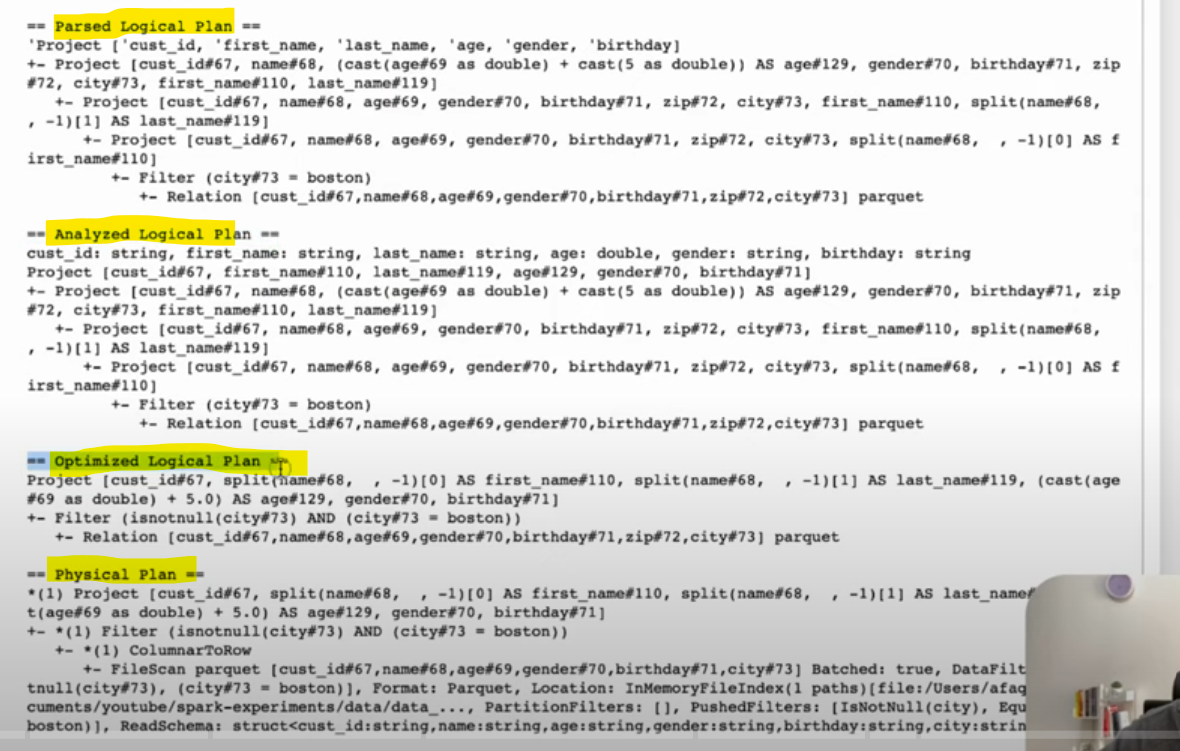

The Physical Plan is the one which is executed on the cluster:
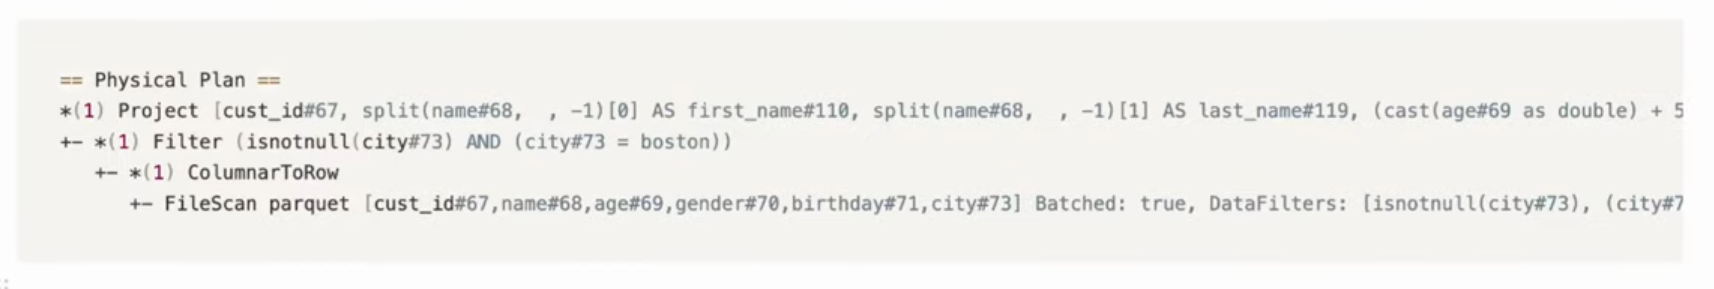

Read from bottom to top like FileScan -> ColumnarToRow -> Filter -> Project---

# Wide Transformations

- Now we will see how the wide transformations to understand how query plan creates on wide transformations.
1. Repartition (
2. Coalesce
3. Joins
4. GroupBy
   - `count`
   - `countDistinct`
   - `sum`

## 1. Repartition

In [ ]:
df_transactions.rdd.getNumPartitions()

In [ ]:
df_transactions.repartition(24).explain(True)

## 2. Coalesce

In [ ]:
df_transactions.coalesce(5).explain(True)

### Why doesn't `.coalesce()` explicitly show the partitioning scheme?

`.coalesce` doesn't show the partitioning scheme e.g. `RoundRobinPartitioning` because: 
- The operation only minimizes data movement by merging into fewer partitions, it doesn't do any shuffling.
- Because no shuffling is done, the partitioning scheme remains the same as the original DataFrame and Spark doesn't include it explicitly in it's plan as the partitioning scheme is unaffected by `.coalesce`

## 3. Joins

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
df_joined = (
    df_transactions.join(
        df_customers,
        how="inner",
        on="cust_id"
    )
)

In [ ]:
df_joined.explain(True)

## 4. GroupBy

In [ ]:
df_transactions.printSchema()

### GroupBy Count

In [ ]:
df_city_counts = (
    df_transactions
    .groupBy("city")
    .count()
)

In [ ]:
df_city_counts.explain(True)

In [ ]:
df_txn_amt_city = (
    df_transactions
    .groupBy("city")
    .agg(F.sum("amt").alias("txn_amt"))
)

In [ ]:
df_txn_amt_city.explain(True)

### GroupBy Count Distinct 

In [ ]:
df_txn_per_city = (
    df_transactions
    .groupBy("cust_id")
    .agg(F.countDistinct("city").alias("city_count"))
)

In [ ]:
df_txn_per_city.show(5, False)
df_txn_per_city.explain(True)

# 5. Interesting Observations

### Why is a filter step present despite predicate pushdown? 

This is largely due to the way `Spark's Catalyst Optimizer` works. Specifically, due to two separate stages of the query optimization process: Physical Planning and Logical Planning.

- **Logical Planning**: Catalyst optimizer simplifies the unresolved logical plan (which represents the user's query) by applying various rule-based optimizations. This includes `predicate pushdown`, `projection pushdown` where filter conditions and column projections are moved as close to the data source as possible.

- **Physical Planning** phase is where the logical plan is translated into one or more physical plans, which can actually be executed on the cluster. This includes operations like file `scans`, `filters`, `projections`, etc.

In this case, during the logical planning phase, the predicate (`F.col("city") == "boston"`) has been pushed down and will be applied during the scan of the Parquet file (`PushedFilters: [IsNotNull(city), EqualTo(city,boston)]`), thus improving performance.

Now, during the physical planning phase, the same filter condition (`+- *(1) Filter (isnotnull(city#73) AND (city#73 = boston))`) is applied again to the data that's been loaded into memory. This is because of the following reasons:

1. **Guaranteed Correctness:** It might seem **redundant**, but remember that not all data sources can handle pushed-down predicates, and not all predicates can be pushed down. Therefore, **even if a predicate is pushed down to the data source, Spark still includes the predicate in the physical plan** to cover cases where the data source might not have been able to fully apply the predicate. This is Spark's way of making sure the correct data is always returned, no matter the capabilities of the data source.

2. **No Assumptions**: Spark's Catalyst optimizer doesn't make assumptions about the data source's ability to handle pushed-down predicates. The optimizer aims to generate plans that return correct results across a wide range of scenarios. Even if the filter is pushed down, Spark does not have the feedback from data source whether the pushdown was successful or not, so it includes the filter operation in the physical plan as well.

It is more of a **fail-safe mechanism** to ensure data **integrity** and **correctness**.

---

### In what cases will predicate pushdown not work?

2 Examples where **filter pushdown** will not work:

1. **Complex Data Types**: Spark's Parquet data source does not push down filters that involve **complex types**, such as **arrays**, **maps**, and **structs**. This is because these complex data types can have complicated nested structures that the Parquet reader cannot easily filter on.

Here's an example:

```
root
 |-- Name: string (nullable = true)
 |-- properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

+----------+-----------------------------+
|Name      |properties                   |
+----------+-----------------------------+
|Afaque    |[eye -> black, hair -> black]|
|Naved     |[eye ->, hair -> brown]      |
|Ali       |[eye -> black, hair -> red]  |
|Amaan     |[eye -> grey, hair -> grey]  |
|Omaira    |[eye -> , hair -> brown]     |
+----------+-----------------------------+
```

```python
df.filter(df.properties.getItem("eye") == "brown").show()
```

```
== Physical Plan ==
*(1) Filter (metadata#123[key] = value)
+- *(1) ColumnarToRow
   +- FileScan parquet [id#122,metadata#123] Batched: true, DataFilters: [(metadata#123[key] = value)], Format: Parquet, ...
```

------------------------------------------------

3. Unsupported Expressions: 

In Spark, `Parquet` data source does not support pushdown for filters involving a `.cast` operation. The reason for this behaviour is as follows:
- `.cast` changes the datatype of the column, and the Parquet data source may not be able to perform the filter operation correctly on the cast data.

**Note**: This behavior may vary based on the data source. For example, if you're working with a JDBC data source connected to a database that supports SQL-like operations, the `.cast` filter could potentially be pushed down to the database.

### Example of operation where filter pushdown doesn't work

In [ ]:
df_customer_gt_50 = (
    df_customers
    .filter(F.col("age").cast("int") > 50)
)
df_customer_gt_50.show(5, False)
df_customer_gt_50.explain(True)